In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


2025-07-07 14:46:34.003101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751899594.209078      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751899594.272577      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = '/kaggle/input/potholes-classification-2/train'
test_dir = '/kaggle/input/potholes-classification-2/test'
valid_dir = '/kaggle/input/potholes-classification-2/valid'


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define training ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define validation/test ImageDataGenerator
test_valid_datagen = ImageDataGenerator(rescale=1./255)


In [4]:

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Updated to 224x224
    batch_size=32,
    class_mode='binary'
)

valid_generator = test_valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),  # Updated to 224x224
    batch_size=32,
    class_mode='binary'
)

test_generator = test_valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Updated to 224x224
    batch_size=32,
    class_mode='binary'
)


Found 14213 images belonging to 2 classes.
Found 2427 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load DenseNet121 without the fully connected layers (top)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the DenseNet121 layers initially
for layer in base_model.layers:
    layer.trainable = False
    
    # Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification (pothole vs no pothole)

# Define the final model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


I0000 00:00:1751899661.745377      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751899661.746029      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 13,460,289 (51.35 MB)

 Trainable params: 6,422,785 (24.50 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,  # Adjust the number of epochs as needed
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1751899786.037187     122 service.cc:148] XLA service 0x79f8f00026f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751899786.038384     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751899786.038405     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751899788.960454     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/444 ━━━━━━━━━━━━━━━━━━━━ 4:01:26 33s/step - accuracy: 0.3750 - loss: 1.4926

I0000 00:00:1751899800.169377     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


444/444 ━━━━━━━━━━━━━━━━━━━━ 312s 631ms/step - accuracy: 0.8009 - loss: 1.0128 - val_accuracy: 0.9329 - val_loss: 0.2026
Epoch 2/25
  1/444 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.8438 - loss: 0.5189

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8438 - loss: 0.5189 - val_accuracy: 0.9329 - val_loss: 0.2042
Epoch 3/25
444/444 ━━━━━━━━━━━━━━━━━━━━ 196s 442ms/step - accuracy: 0.8646 - loss: 0.3071 - val_accuracy: 0.9233 - val_loss: 0.1817
Epoch 4/25
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9062 - loss: 0.2604 - val_accuracy: 0.9233 - val_loss: 0.1805
Epoch 5/25
444/444 ━━━━━━━━━━━━━━━━━━━━ 189s 426ms/step - accuracy: 0.8665 - loss: 0.3059 - val_accuracy: 0.9404 - val_loss: 0.1497
Epoch 6/25
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8750 - loss: 0.2285 - val_accuracy: 0.9408 - val_loss: 0.1513
Epoch 7/25
444/444 ━━━━━━━━━━━━━━━━━━━━ 188s 423ms/step - accuracy: 0.8660 - loss: 0.2950 - val_accuracy: 0.9337 - val_loss: 0.1635
Epoch 8/25
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8125 - loss: 0.1924 - val_accuracy: 0.9329 - val_loss: 0.1645
Epoch 9/25
444/444 ━━━━━━━━━━━━━━━━━━━━ 189s 425ms/step - accuracy: 0.8820 - loss: 0.2742 - val_acc

In [8]:
# Unfreeze the last few layers of DenseNet121
for layer in base_model.layers[-10:]:
    layer.trainable = True  # Unfreeze the last 10 layers (adjust as necessary)

# Recompile the model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Fine-tune for additional epochs
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 249s 495ms/step - accuracy: 0.8797 - loss: 0.2516 - val_accuracy: 0.9379 - val_loss: 0.1533
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7812 - loss: 0.2179 - val_accuracy: 0.9379 - val_loss: 0.1529
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 191s 430ms/step - accuracy: 0.8832 - loss: 0.2594 - val_accuracy: 0.9421 - val_loss: 0.1513
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9062 - loss: 0.6780 - val_accuracy: 0.9408 - val_loss: 0.1522
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 189s 426ms/step - accuracy: 0.8884 - loss: 0.2551 - val_accuracy: 0.9425 - val_loss: 0.1533
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8750 - loss: 0.2359 - val_accuracy: 0.9433 - val_loss: 0.1518
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 189s 427ms/step - accuracy: 0.8906 - loss: 0.2471 - val_accuracy: 0.9438 - val_loss: 0.1482
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9062 - loss: 0.181

In [9]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9349 - loss: 0.1534
Test Loss: 0.1584431678056717
Test Accuracy: 0.9307432174682617


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


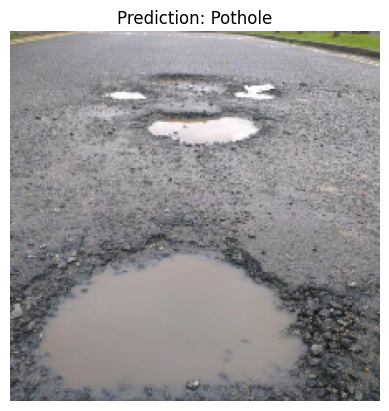

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path to the image you want to predict
img_path = '/kaggle/input/potholes-classification-2/test/Pothole/1126_jpg.rf.5084c25a89a81444e0c84c6b3f14dd3a.jpg'  # Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image
img_array = image.img_to_array(img)  # Convert image to array
img_array = img_array / 255.0  # Rescale the image to match the model's input
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(img_array)

# Show the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title("Prediction: Pothole" if prediction[0] > 0.5 else "Prediction: No Pothole")
plt.show()


In [13]:
# Ground truth for the image (True Label)
true_label = 1  # If the image is a pothole, set it to 1, otherwise 0

# Compare predicted label with the true label
prediction = model.predict(img_array)
predicted_label = 1 if prediction[0] > 0.5 else 0  # If prediction > 0.5, it's Pothole (1), otherwise No Pothole (0)

# Check if the prediction is correct
correct = (predicted_label == true_label)
accuracy = (correct * 100)  # 100% if correct, 0% if incorrect

print(f"Prediction: {'Pothole' if predicted_label == 1 else 'No Pothole'}")
print(f"Accuracy: {accuracy}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction: Pothole
Accuracy: 100%


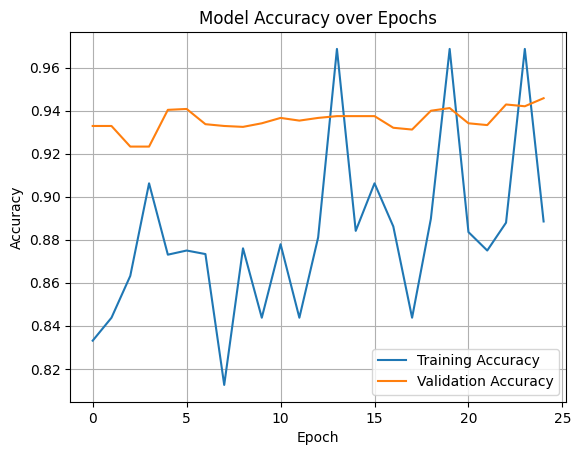

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [16]:
from tensorflow.keras.callbacks import Callback

class TestAccuracyCallback(Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(
            self.test_generator,
            steps=self.test_generator.samples // self.test_generator.batch_size,
            verbose=0
        )
        self.test_accuracies.append(acc)
        print(f"\nTest accuracy after epoch {epoch+1}: {acc:.4f}")


In [17]:
# Initialize the callback
test_callback = TestAccuracyCallback(test_generator)

# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[test_callback]
)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8947 - loss: 0.2341
Test accuracy after epoch 1: 0.9316
444/444 ━━━━━━━━━━━━━━━━━━━━ 212s 477ms/step - accuracy: 0.8947 - loss: 0.2341 - val_accuracy: 0.9446 - val_loss: 0.1497
Epoch 2/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.8438 - loss: 0.1697
Test accuracy after epoch 2: 0.9316
444/444 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.8438 - loss: 0.1697 - val_accuracy: 0.9442 - val_loss: 0.1502
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8910 - loss: 0.2418
Test accuracy after epoch 3: 0.9341
444/444 ━━━━━━━━━━━━━━━━━━━━ 201s 453ms/step - accuracy: 0.8910 - loss: 0.2418 - val_accuracy: 0.9442 - val_loss: 0.1476
Epoch 4/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.8438 - loss: 0.1781
Test accuracy after epoch 4: 0.9333
444/444 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8438 - loss: 0.1781 - val_accuracy: 0.9442 - val_loss: 0.1480
Epoch 5/10
444/444 ━━━━━

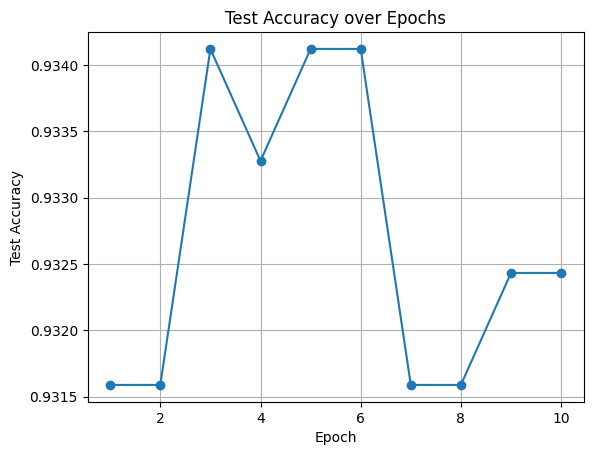

In [18]:
# Plot test accuracy per epoch
plt.plot(range(1, len(test_callback.test_accuracies) + 1), test_callback.test_accuracies, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


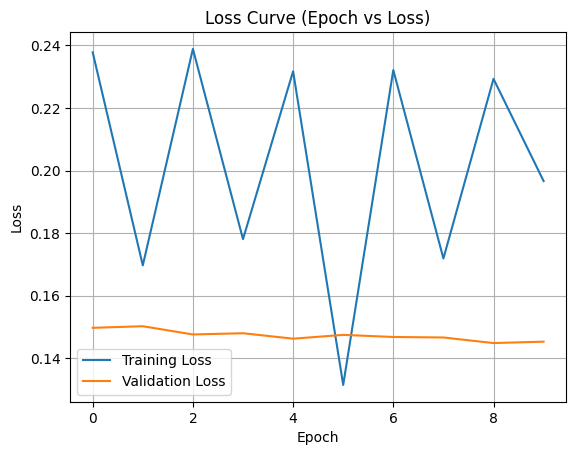

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss Curve (Epoch vs Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Reset the generator to start from the beginning
train_generator.reset()

# Initialize lists for true labels and predictions
train_labels = []
train_predictions = []

# Iterate through the batches
for i in range(train_generator.samples // train_generator.batch_size):
    images, labels = next(train_generator)  # Get batch
    predictions = model.predict(images, verbose=0)  # Predict batch
    train_labels.extend(labels)
    train_predictions.extend(np.round(predictions))  # Round to 0 or 1

# Convert to numpy arrays
train_labels = np.array(train_labels).astype(int)
train_predictions = np.array(train_predictions).astype(int)

# Generate and print confusion matrix
cm_train = confusion_matrix(train_labels, train_predictions)
print("Confusion Matrix for Training Data:")
print(cm_train)


Confusion Matrix for Training Data:
[[6456  436]
 [ 663 6653]]


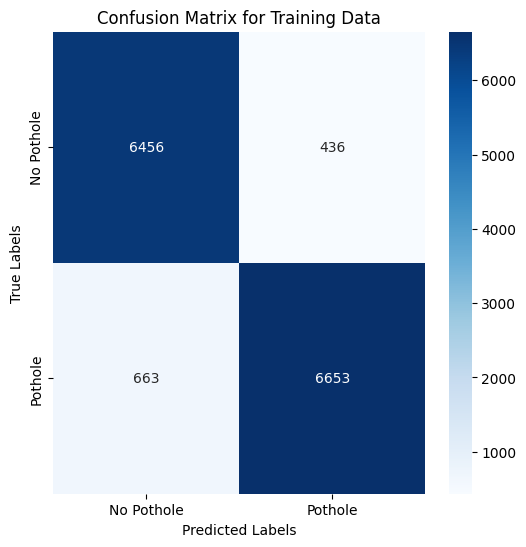

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the training data
cm_train = confusion_matrix(train_labels, train_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pothole', 'Pothole'], yticklabels=['No Pothole', 'Pothole'])
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming train_labels and train_predictions are already defined (from previous steps)

# Calculate Accuracy
accuracy = accuracy_score(train_labels, train_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision
precision = precision_score(train_labels, train_predictions)
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(train_labels, train_predictions)
print(f"Recall: {recall:.4f}")

# Calculate F1 Score
f1 = f1_score(train_labels, train_predictions)
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9226
Precision: 0.9385
Recall: 0.9094
F1 Score: 0.9237


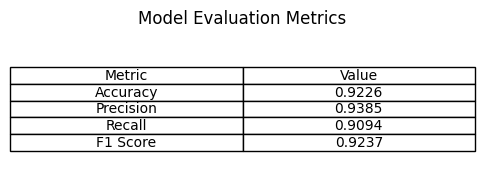

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate the metrics
accuracy = accuracy_score(train_labels, train_predictions)
precision = precision_score(train_labels, train_predictions)
recall = recall_score(train_labels, train_predictions)
f1 = f1_score(train_labels, train_predictions)

# Create the data for the table
metrics = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}']
]

# Plotting the table
fig, ax = plt.subplots(figsize=(6, 2))  # Set size of the figure
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics, colLabels=['Metric', 'Value'], loc='center', cellLoc='center')

# Display the table
plt.title("Model Evaluation Metrics")
plt.show()


In [27]:
# Save the model
model.save('DenseNet121.h5')  # Save as a .h5 file

print("Model saved successfully!")


Model saved successfully!


In [26]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /kaggle/working
